In [15]:
import tensorflow as tf
from tensorflow.keras.models import clone_model
from model_utils import simplecnn
import numpy as np

In [16]:
import tensorflow as tf
gpus = tf.config.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu, enable=True)

In [17]:
class clint_k():
    def __init__(self, name, dataset, model, 
                optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3),
                loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
                ):
        self.name = name
        self.dataset = dataset  
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
        self.attri = {'name':self.name, 'dataset':self.dataset, 'optimizer': self.optimizer,
                     'loss_fn' : self.loss_fn}
        
        self.model.compile(self.optimizer, loss_fn,
                          metrics=metrics)
        self.warmingUp = False
        
    def get_config(self):
        config = self.attri
        config['model'] = self.model
        config['optimizer'] = self.optimizer
        config['loss_fn'] = self.loss_fn
        config['warmingUp'] = self.warmingUp
        return self.attri

In [18]:
from utils import *

def split_client(x, y, method = bySample_bal_split, K = 6):
    
    K = K

    split_method = {}
    # split_method['method'] = lambda x,y,k : byClasses_inbal_split(x,y,k)
    split_method['method'] = bySample_bal_split


    subset= split_method['method'](x, y, K)
    view_clientDict(subset)
    return subset
    

In [19]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 標準化數據
X_train = X_train/255.0
X_test = X_test/255.0
print(X_train.shape)
print(X_train[0].shape)

idx = np.argsort(y_train)
x_train_sorted = X_train[idx]
y_train_sorted = y_train[idx]

(60000, 28, 28)
(28, 28)


In [20]:
hyper_para = dict()

hyper_para['C'] = 0.3

if not 'k_' in list(locals().keys()):
    hyper_para['K'] = 12
else:
    hyper_para['K'] = k_ # argparse

hyper_para['B'] = 1024 # faster?

hyper_para['mu'] = 0.01

>>> 分割給 12 個client
>>> subset client0 資料維度
-- data shape (5000, 28, 28) --label shape (5000,)
>>> subset client11 資料維度
-- data shape (5000, 28, 28) --label shape (5000,)


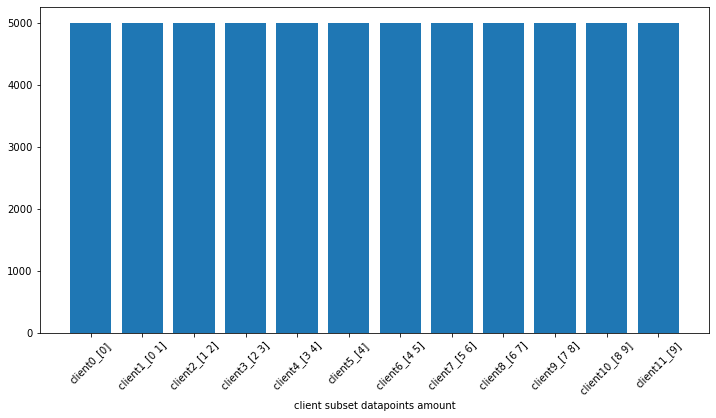

client0
client1
client2
client3
client4
client5
client6
client7
client8
client9
client10
client11


In [21]:
from tensorflow.keras.models import clone_model


Gmodel = simplecnn('server_model')
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
optimizer = tf.keras.optimizers.SGD()
# optimizer = PerturbedGradientDescent(mu=hyper_para['mu']
Gmodel.compile(optimizer, loss_fn, metrics)

# print(Gmodel.trainable_variables)
# hyper_para = dict()

# if not 'k_' in list(locals().keys()):
#     hyper_para['K'] = 12
# else:
#     hyper_para['K'] = k_ # argparse

# hyper_para['B'] = 1024 # faster?
B = hyper_para['B']

hyper_para['split_method'] = str(bySample_bal_split).split(' ')[1]

subset = split_client(x_train_sorted, y_train_sorted, bySample_bal_split, hyper_para['K'])

client_list = dict() 

for _ in list(subset.keys()):
    
    train_dataset = tf.data.Dataset.from_tensor_slices((subset[_][0], subset[_][1])).batch(B).prefetch(B).shuffle(buffer_size=1024)
    
    tmp_model = tf.keras.models.clone_model(Gmodel)
    tmp_model.set_weights(Gmodel.get_weights())
    
    client_list[_] = clint_k(name=_, dataset=train_dataset, model=tmp_model,
#                optimizer = PerturbedGradientDescent(mu=hyper_para['mu']))
                             optimizer = optimizer)
#     client_list[_].model.set_weights(Gmodel.get_weights())
    
    print(client_list[_].name)
#     client_list[_].warming_up()


In [22]:
def model_equal_validation(model1, model2, display=False, string=''):
#     print(string)
    true_lis = []
    for layer in range(len(model1.trainable_variables)):
        a = np.array_equal(model1.trainable_variables[layer].numpy(),
                         model2.trainable_variables[layer].numpy())
        true_lis.append(a)
    if display:
        print(string,'\t>>>', all(true_lis))
#     string_ = string+'  >>>'+ str(all(true_lis))
    return all(true_lis)

In [23]:
model_equal_validation(model1 = client_list['client0'].model, 
                       model2 = client_list['client1'].model)

True

In [24]:
client_list

{'client0': <__main__.clint_k at 0x7f19611adb10>,
 'client1': <__main__.clint_k at 0x7f196117ff50>,
 'client2': <__main__.clint_k at 0x7f1820703410>,
 'client3': <__main__.clint_k at 0x7f19610f85d0>,
 'client4': <__main__.clint_k at 0x7f19610da450>,
 'client5': <__main__.clint_k at 0x7f1961095e10>,
 'client6': <__main__.clint_k at 0x7f196104edd0>,
 'client7': <__main__.clint_k at 0x7f196100be10>,
 'client8': <__main__.clint_k at 0x7f1960fa9a10>,
 'client9': <__main__.clint_k at 0x7f1960fe6410>,
 'client10': <__main__.clint_k at 0x7f1960f40290>,
 'client11': <__main__.clint_k at 0x7f1960f4d6d0>}

In [25]:
for i in client_list:
    k = client_list[i]
#     print(k.model.trainable_variables[1])
    print(k.optimizer)

In [26]:
print("---\nEvaluate on Global test data on Gmodel")
results = Gmodel.evaluate(X_test[:], y_test[:], batch_size=128)
print("test loss, test acc:", results,'\n')

---
Evaluate on Global test data on Gmodel
79/79 [==============================] - 0s 2ms/step - loss: 2.3034 - sparse_categorical_accuracy: 0.0964
test loss, test acc: [2.303356885910034, 0.09640000015497208] 



In [27]:
print(int(np.ceil(hyper_para['C']*len(client_list))))

4


In [28]:
import random
from tqdm.auto import tqdm, trange

# def round_train(client_list, hyper_para, rounds):
    
    
    

#     print(choice)

rounds = 100
# start training

all_samples = 0
for i in client_list:
    k = client_list[i]
    all_samples += np.sum([len(y) for (x,y) in k.dataset])
print('all client sample sum', all_samples)
for rd in trange(rounds):
#     print('>>>start of round')

    # select client set S_t for t-th round from all clients set S. 
    size = int(np.ceil(hyper_para['C']*len(client_list)))
    
#     size = 4
    choice = random.sample(list(client_list.keys()), size)
#     print('participate client ',choice)

    models = []
    
#     #     ================================================================= Check
#     print('\nWhether each client as same as Gmodel before round start?')
#     for i in client_list:
#         k = client_list[i]
#         string = i+' is as same as Gmodel?'
#         print(model_equal_validation(string, k.model, Gmodel))
# #     ================================================================= Check
    sum_samples = 0
    for i in choice:
        k = client_list[i]
        sum_samples += np.sum([len(y) for (x,y) in k.dataset])
#     print('selected client sample sum', sum_samples, all_samples)
    
    for key in choice: 
        k = client_list[key]

        dataset = k.dataset
        k.model.fit(dataset, epochs=3, verbose=0)
        
        

        a = np.sum([len(y) for (x,y) in k.dataset])/sum_samples # compute Average weighting weight for this client
#         a = 1 # ? 
        b = k.model.trainable_variables # get weight 
        c = [l*a for l in b] # multiply weighting in every layer 

        models.append(c)
    
    # model aggregate

    new_weights = list()
    if len(models) == 1:
        print('only single participant')
        new_weights = models[0]
    else:
        for i in zip(*models):
#             print(tf.shape(i))
#             new_weights.append(tf.reduce_mean(i, axis=0))
            new_weights.append(tf.reduce_sum(i, axis=0))
#             print(tf.shape(i))
#             print(tf.reduce_sum(i, axis=0).shape)

    Gmodel.set_weights(new_weights)
    for i in client_list:
        k = client_list[i] 
        k.model.set_weights(Gmodel.get_weights())
#         k.optimizer.set_params(k.model)
        

#     print('>>>end of round\n') 
# round_train(client_list, hyper_para, 200)

all client sample sum 60000


ResourceExhaustedError:  OOM when allocating tensor with shape[1024,32,24,24] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node server_model/conv2d_5/Relu (defined at <ipython-input-28-d754925283ca>:48) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_7833]

Function call stack:
train_function


In [ ]:
print("---\nEvaluate on Global test data on Gmodel")
results = Gmodel.evaluate(X_test[:], y_test[:], batch_size=128)
print("test loss, test acc:", results,'\n')